# imports

In [9]:
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
# import seaborn as sns; sns.set_theme(font='Malgun Gothic')

pd.set_option('display.max_rows', 100, 'display.max_columns', 100, 'max_colwidth', None)
import warnings; warnings.filterwarnings(action='ignore')

# 숫자 잘린거 다 보여주기
pd.options.display.float_format = '{:.5f}'.format

In [10]:
# !pip install -U finance-datareader

In [11]:
import talib
from pandas_datareader import data
import FinanceDataReader as fdr

# read

In [12]:
# kospi  = fdr.DataReader('KS11', '1980') # 1980 ~ 오늘
kospi = pd.read_csv('./kospi.csv')
sp500  = fdr.DataReader('US500', '2019') # 2019 ~ 오늘
nasdaq = fdr.DataReader('NDAQ', '2019') # 2019 ~ 오늘
# 코스피('KS11'), S&P 500('US500'), 나스닥('NDAQ')
# CD금리, 미 국채 ETF 필요

In [24]:
kospi['Change'] = kospi['Close'].pct_change()

In [25]:
# sp500_a  = fdr.DataReader('US500', '1995') # 2019 ~ 오늘

In [26]:
# nasdaq_a= fdr.DataReader('NDAQ', '1995') # 2019 ~ 오늘
# nasdaq_a

In [27]:
kospi.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Change
4652,2021-11-08,2968.17993,2930.89990,2965.36011,2960.19995,559600.00000,2960.19995,-0.00305
4653,2021-11-09,2987.28003,2949.16992,2958.14990,2962.45996,707800.00000,2962.45996,0.00076
4654,2021-11-10,2958.61011,2924.36011,2947.45996,2930.16992,567300.00000,2930.16992,-0.01090
4655,2021-11-11,2925.18994,2903.71997,2911.40991,2924.91992,571900.00000,2924.91992,-0.00179
4656,2021-11-12,2973.84009,2938.27002,2945.94995,2968.80005,665000.00000,2968.80005,0.01500


# ta-library 사용

In [28]:
# dir(talib)
# ?talib.STDDEV

In [29]:
kospi2 = kospi.copy()

# 사전정의함수

In [30]:
def getPsy(x):
    """심리도 사전 정의 함수"""
    if x > 0:
        result = 1
    else:
        result = np.nan
    return result

def getRevPlus(a):
    if a > 0:
        result = a
    else:
        result = 0
    return result

def getRevMinus(a):
    if a < 0:
        result = a
    else:
        result = 0
    return result

def getVRplus(a, b):
    if a > 0:
        result = b
    else:
        result = 0
    return result

def getVRminus(a, b):
    if a < 0:
        result = b
    else:
        result = 0
    return result

# 보조지표 함수

In [31]:
def getIndicators(df):

# Moving Average : 주가이동평균
    df['MA5'] = talib.MA(df['Close'], timeperiod=5)
    df['MA20'] = talib.MA(df['Close'], timeperiod=20)
    df['MA60'] = talib.MA(df['Close'], timeperiod=60)
    df['MA120'] = talib.MA(df['Close'], timeperiod=120)

# 가격이동평균 기울기 : (당일 이동평균 - 전날 이동평균) / 전날 이동평균
    df['MA5_gra'] = (df['MA5'] - df['MA5'].shift(1)) / df['MA5'].shift(1)
    df['MA20_gra'] = (df['MA20'] - df['MA20'].shift(1)) / df['MA20'].shift(1)
    df['MA60_gra'] = (df['MA60'] - df['MA60'].shift(1)) / df['MA60'].shift(1)
    df['MA120_gra'] = (df['MA120'] - df['MA120'].shift(1)) / df['MA120'].shift(1)    

# 거래량이동평균
    df['V_MA5'] = talib.MA(df['Volume'], timeperiod=5)
    df['V_MA20'] = talib.MA(df['Volume'], timeperiod=20)
    df['V_MA60'] = talib.MA(df['Volume'], timeperiod=60)
    df['V_MA120'] = talib.MA(df['Volume'], timeperiod=120)

# 지수이동평균
    df['EMA5'] = talib.EMA(df['Close'], timeperiod=5)
    df['EMA20'] = talib.EMA(df['Close'], timeperiod=20)
    df['EMA60'] = talib.EMA(df['Close'], timeperiod=60)
    df['EMA120'] = talib.EMA(df['Close'], timeperiod=120)   

# MACD
    macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_sig9'] = macdsignal
    df['MACD_OSC'] = macdhist

# Stochastic
    fastk, fastd = talib.STOCHF(df['High'], df['Low'], df['Close'], fastk_period=14, fastd_period=3)
    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period=14, slowk_period=5, slowd_period=3)
    df['Fast%K'] = fastk
    df['Fast%D'] = fastd
    df['Slow%K'] = slowk
    df['Slow%D'] = slowd

# RSI: 9일, 14일, 15일, 25일, 28일 (RSI_sig 9일)
    df_index = df.index.astype('str')
    U = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    D = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U, index = df_index).rolling(window=14).mean() # RSI: 14일
    AD = pd.DataFrame(D, index = df_index).rolling(window=14).mean()
    RSI = AU / (AD+AU) * 100

    df.insert(len(df.columns), "RSI14", RSI)
    df.insert(len(df.columns), "RSI signal", df['RSI14'].ewm(span=9).mean())

# CCI (14일 기준)
    M = (df['High']+df['Low']+df['Close'])/3
    m = M.rolling(window=14).mean()
    d = abs(M-m).rolling(window=14).mean()
    df['CCI'] =( M - m )/(d*0.015)
    df['CCI'] = np.where(df['CCI'] > 0, df['CCI'] + 0.5, df['CCI'] - 0.5)

# A ratio
    df['A'] = (df['High'] - df['Open']).rolling(window=20).sum() / (df['Open'] - df['Low']).rolling(window=20).sum()
    df['A_Ratio'] = df['A']*100

# B ratio
    df['B'] = (df['High'] - df['Close'].shift(1)).rolling(window=20).sum() / (df['Close'].shift(1) - df['Low']).rolling(window=20).sum()
    df['B_Ratio'] = df['B']*100


    df.drop(['A', 'B'], axis=1, inplace=True)

# ATR(14일 기준)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

# DMI
    df['UpDI'] = talib.PLUS_DI(df['High'], df['Low'],  df['Close'], timeperiod=14)
    df['DownDI'] = talib.MINUS_DI(df['High'], df['Low'],  df['Close'], timeperiod=14)

# MFI
    df['MFI'] = talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=14)

# Momentum
    df['Momentum'] = talib.MOM(df['Close'], timeperiod=12)

# Sonar
    df['EMA9'] = talib.EMA(df['Close'], timeperiod=9)
    df['n_shift_ema'] = df['EMA9'].shift(9)
    df['Sonar'] = df['EMA9'] - df['n_shift_ema']
    df['Sonar_sig5'] = talib.EMA(df['Sonar'], timeperiod=5)
    
    df.drop('EMA9', axis=1, inplace= True)

    df.drop('n_shift_ema', axis=1, inplace=True)

# STDEV(20일 표준편차)
    df['STDEV'] = talib.STDDEV(df['Close'], timeperiod=20)

# Sigma(20일) (20일짜리 표준편차 사용)
    df['Sigma'] = ( df['Close'] - df['Close'].rolling(window=20).mean() ) / df['STDEV']

# TRIX(12일) (퍼센트)
    df['TRIX'] = talib.TRIX(df['Close'], timeperiod=12)

# VR : 주가 상승일 거래량 / 주가 하락일 거래량 * 100, 
    df['VRplus']  = df.apply(lambda x: getVRplus(x['Change'], x['Volume']), axis=1)
    df['VRminus'] = df.apply(lambda x: getVRminus(x['Change'], x['Volume']), axis=1)

    df['VRplus_rolling']  = df['VRplus'].rolling(window=20).sum() # period: 20
    df['VRminus_rolling'] = df['VRminus'].rolling(window=20).sum()

    df['VR'] = df['VRplus_rolling'] / df['VRminus_rolling'] * 100

    df.drop(['VRplus', 'VRminus', 'VRplus_rolling', 'VRminus_rolling'], axis=1, inplace=True)

# William's %R (14일)
    df['WILLR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

# 심리도
    df['psy_temp'] = df.apply(lambda x: getPsy(x['Change']), axis=1)
    df['Psy']      = df['psy_temp'].rolling(window=10).count() / 10 * 100
    df.drop('psy_temp', axis=1, inplace=True)

# 이격도
    df['Disparity20'] = (df['Close'] / df['Close'].rolling(window=20).mean()) * 100
    df['Disparity60'] = (df['Close'] / df['Close'].rolling(window=60).mean()) * 100

# ADX
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)

# Chaikin's OSC
    df['ADOSC'] = talib.ADOSC(df['High'], df['Low'], df['Close'], df['Volume'], fastperiod=3, slowperiod=10)

# 거래량 OSC(10일, 20일, 9일)
    df['Volume_OSC'] = (df['Volume'].rolling(window=10).mean() - df['Volume'].rolling(window=20).mean()) / df['Volume'].rolling(window=10).mean() * 100

# 볼린저 밴드
    df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)



    return df

In [32]:
kospi2.drop(index=4521, inplace= True)

In [33]:
getIndicators(kospi2).tail()

,Date,High,Low,Open,Close,Volume,Adj Close,Change,MA5,MA20,MA60,MA120,MA5_gra,MA20_gra,MA60_gra,MA120_gra,V_MA5,V_MA20,V_MA60,V_MA120,EMA5,EMA20,EMA60,EMA120,MACD,MACD_sig9,MACD_OSC,Fast%K,Fast%D,Slow%K,Slow%D,RSI14,RSI signal,CCI,A_Ratio,B_Ratio,ATR,UpDI,DownDI,MFI,Momentum,Sonar,Sonar_sig5,STDEV,Sigma,TRIX,VR,WILLR,Psy,Disparity20,Disparity60,ADX,ADOSC,Volume_OSC,upperband,middleband,lowerband
4652,2021-11-08,2968.17993,2930.89990,2965.36011,2960.19995,559600.00000,2960.19995,-0.00305,2980.37798,2994.14998,3082.10299,3161.13932,-0.00126,0.00007,-0.00167,-0.00043,640480.00000,686055.00000,702151.66667,938652.50000,2975.26103,3000.88285,3067.28855,3091.04962,-22.99930,-23.76823,0.76893,24.26505,20.19936,25.96580,31.27176,36.51889,47.25635,-121.61351,51.68219,145.60348,40.01761,16.21243,33.44346,29.35320,-47.13013,-31.41407,-14.33350,31.11496,-1.09112,-0.08922,82.40080,-75.73495,40.00000,98.86612,96.04481,29.33799,-741621.74381,-14.12946,3056.37989,2994.14998,2931.92006
4653,2021-11-09,2987.28003,2949.16992,2958.14990,2962.45996,707800.00000,2962.45996,0.00076,2970.17197,2996.45398,3077.13700,3159.54882,-0.00342,0.00077,-0.00161,-0.00050,676960.00000,688465.00000,702173.33333,937587.50000,2970.99401,2997.22353,3063.85155,3088.92417,-23.37920,-23.69042,0.31122,26.13669,22.02461,19.73770,25.52947,39.51673,45.70842,-79.59347,63.62194,186.70655,39.88136,18.52671,31.16074,37.00661,-43.69995,-37.73726,-22.13476,26.65775,-1.27520,-0.09114,100.63384,-73.86331,40.00000,98.86553,96.27326,29.05864,-679889.16534,-11.85641,3049.76948,2996.45398,2943.13848
4654,2021-11-10,2958.61011,2924.36011,2947.45996,2930.16992,567300.00000,2930.16992,-0.01090,2961.06396,2995.74198,3071.92000,3157.84590,-0.00307,-0.00024,-0.00170,-0.00054,658760.00000,679250.00000,699478.33333,935892.50000,2957.38598,2990.83747,3059.46854,3086.30013,-25.98626,-24.14959,-1.83667,4.56424,18.32200,18.25981,21.32110,35.61307,43.68935,-126.07314,54.05089,149.35357,39.75411,17.25844,33.48532,38.42288,-90.37012,-46.06583,-30.11178,28.18472,-2.32651,-0.09695,82.83492,-95.43576,40.00000,97.81116,95.38562,29.26717,-712093.53364,-11.08476,3052.11141,2995.74198,2939.37255
4655,2021-11-11,2925.18994,2903.71997,2911.40991,2924.91992,571900.00000,2924.91992,-0.00179,2949.40396,2992.55598,3066.99166,3155.77815,-0.00394,-0.00106,-0.00160,-0.00065,618800.00000,677015.00000,698731.66667,934113.33333,2946.56396,2984.55961,3055.05711,3083.63269,-28.15149,-24.94997,-3.20152,14.33108,15.01067,16.99383,18.33044,35.07937,41.96736,-140.77940,52.43775,111.93562,38.80382,16.41816,35.65434,39.04904,-124.16016,-46.00467,-35.40941,32.13244,-2.10491,-0.10505,69.20933,-85.66892,40.00000,97.73986,95.36772,29.81531,-483141.17746,-11.54011,3056.82087,2992.55598,2928.29110
4656,2021-11-12,2973.84009,2938.27002,2945.94995,2968.80005,665000.00000,2968.80005,0.01500,2949.30996,2990.24298,3062.99866,3154.16582,-0.00003,-0.00077,-0.00130,-0.00051,614320.00000,667400.00000,699105.00000,933208.33333,2953.97599,2983.05870,3052.22901,3081.73463,-26.02667,-25.16531,-0.86136,43.99385,20.96306,22.65818,19.30394,41.42641,41.85917,-48.04459,57.51255,118.00965,39.52641,23.75834,32.50235,38.05768,-56.68994,-38.83171,-36.55018,32.09423,-0.66812,-0.10834,66.80621,-56.00615,50.00000,99.28290,96.92463,28.79578,-193928.02841,-7.82951,3054.43144,2990.24298,2926.05453


In [35]:
kospi2['T3'] = talib.EMA(talib.EMA(talib.EMA(kospi2['Close'], timeperiod=20), timeperiod=20), timeperiod=20)    

<AxesSubplot:>

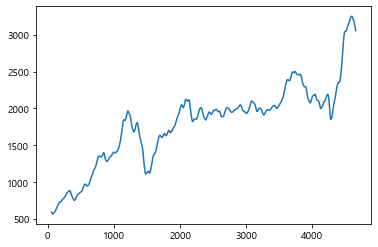

In [36]:
kospi2['T3'].plot()

<AxesSubplot:>

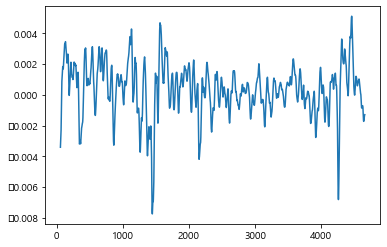

In [39]:
kospi2['T3'].pct_change().plot()

<AxesSubplot:>

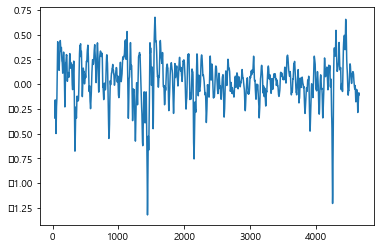

In [38]:
kospi2['TRIX'].plot()

In [34]:
adfasfafafasf

NameError: name 'adfasfafafasf' is not defined

# Close → Volume

In [ ]:
kospi3 = kospi.copy()

In [ ]:
def V_getIndicators(df):
    
# Moving Average : 가격이동평균
    df['MA5'] = talib.MA(df['Close'], timeperiod=5)
    df['MA20'] = talib.MA(df['Close'], timeperiod=20)
    df['MA60'] = talib.MA(df['Close'], timeperiod=60)
    df['MA120'] = talib.MA(df['Close'], timeperiod=120)

# 가격이동평균 기울기 : (당일 이동평균 - 전날 이동평균) / 전날 이동평균
    df['MA5_gra'] = (df['MA5'] - df['MA5'].shift(1)) / df['MA5'].shift(1)
    df['MA20_gra'] = (df['MA20'] - df['MA20'].shift(1)) / df['MA20'].shift(1)
    df['MA60_gra'] = (df['MA60'] - df['MA60'].shift(1)) / df['MA60'].shift(1)
    df['MA120_gra'] = (df['MA120'] - df['MA120'].shift(1)) / df['MA120'].shift(1)    

# 거래량이동평균
    df['V_MA5'] = talib.MA(df['Volume'], timeperiod=5)
    df['V_MA20'] = talib.MA(df['Volume'], timeperiod=20)
    df['V_MA60'] = talib.MA(df['Volume'], timeperiod=60)
    df['V_MA120'] = talib.MA(df['Volume'], timeperiod=120)
    
# 거래량이동평균 기울기 ★
    df['V_MA5_gra'] = (df['V_MA5'] - df['V_MA5'].shift(1)) / df['V_MA5'].shift(1)
    df['V_MA20_gra'] = (df['V_MA20'] - df['V_MA20'].shift(1)) / df['V_MA20'].shift(1)
    df['V_MA60_gra'] = (df['V_MA60'] - df['V_MA60'].shift(1)) / df['V_MA60'].shift(1)
    df['V_MA120_gra'] = (df['V_MA120'] - df['V_MA120'].shift(1)) / df['V_MA120'].shift(1)

# 지수이동평균
    df['EMA5'] = talib.EMA(df['Close'], timeperiod=5)
    df['EMA20'] = talib.EMA(df['Close'], timeperiod=20)
    df['EMA60'] = talib.EMA(df['Close'], timeperiod=60)
    df['EMA120'] = talib.EMA(df['Close'], timeperiod=120)   
    
# (거래량)지수이동평균 ★
    df['V_EMA5'] = talib.EMA(df['Volume'], timeperiod=5)
    df['V_EMA20'] = talib.EMA(df['Volume'], timeperiod=20)
    df['V_EMA60'] = talib.EMA(df['Volume'], timeperiod=60)
    df['V_EMA120'] = talib.EMA(df['Volume'], timeperiod=120)
        
# MACD
    macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_sig9'] = macdsignal
    df['MACD_OSC'] = macdhist
    
# MACD ★
    macd, macdsignal, macdhist = talib.MACD(df['Volume'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['V_MACD'] = macd
    df['V_MACD_sig9'] = macdsignal
    df['V_MACD_OSC'] = macdhist

# Stochastic
    fastk, fastd = talib.STOCHF(df['High'], df['Low'], df['Close'], fastk_period=14, fastd_period=3)
    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period=14, slowk_period=5, slowd_period=3)
    df['Fast%K'] = fastk
    df['Fast%D'] = fastd
    df['Slow%K'] = slowk
    df['Slow%D'] = slowd

# RSI: 9일, 14일, 15일, 25일, 28일 (RSI_sig 9일)
    df_index = df.index.astype('str')
    U = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    D = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U, index = df_index).rolling(window=14).mean() # RSI: 14일
    AD = pd.DataFrame(D, index = df_index).rolling(window=14).mean()
    RSI = AU / (AD+AU) * 100

    df.insert(len(df.columns), "RSI14", RSI)
    df.insert(len(df.columns), "RSI signal", df['RSI14'].ewm(span=9).mean())
    
# RSI: 9일, 14일, 15일, 25일, 28일 (RSI_sig 9일) ★
    df_index = df.index.astype('str')
    U = np.where(df['Volume'].diff(1) > 0, df['Volume'].diff(1), 0)
    D = np.where(df['Volume'].diff(1) < 0, df['Volume'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U, index = df_index).rolling(window=14).mean() # RSI: 14일
    AD = pd.DataFrame(D, index = df_index).rolling(window=14).mean()
    RSI = AU / (AD+AU) * 100

    df.insert(len(df.columns), "V_RSI14", RSI)
    df.insert(len(df.columns), "V_RSI signal", df['V_RSI14'].ewm(span=9).mean())

# CCI (14일 기준)
    M = (df['High']+df['Low']+df['Close'])/3
    m = M.rolling(window=14).mean()
    d = abs(M-m).rolling(window=14).mean()
    df['CCI'] =( M - m )/(d*0.015)
    df['CCI'] = np.where(df['CCI'] > 0, df['CCI'] + 0.5, df['CCI'] - 0.5)

# A ratio
    df['A'] = (df['High'] - df['Open']).rolling(window=20).sum() / (df['Open'] - df['Low']).rolling(window=20).sum()
    df['A_Ratio'] = df['A']*100

# B ratio
    df['B'] = (df['High'] - df['Close'].shift(1)).rolling(window=20).sum() / (df['Close'].shift(1) - df['Low']).rolling(window=20).sum()
    df['B_Ratio'] = df['B']*100


    df.drop(['A', 'B'], axis=1, inplace=True)

# ATR(14일 기준)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

# DMI
    df['UpDI'] = talib.PLUS_DI(df['High'], df['Low'],  df['Close'], timeperiod=14)
    df['DownDI'] = talib.MINUS_DI(df['High'], df['Low'],  df['Close'], timeperiod=14)

# MFI
    df['MFI'] = talib.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=14)

# Momentum
    df['Momentum'] = talib.MOM(df['Close'], timeperiod=12)
    
# Momentum ★
    df['V_Momentum'] = talib.MOM(df['Volume'], timeperiod=12)

# Sonar
    df['EMA9'] = talib.EMA(df['Close'], timeperiod=9)
    df['n_shift_ema'] = df['EMA9'].shift(9)
    df['Sonar'] = df['EMA9'] - df['n_shift_ema']
    df['Sonar_sig5'] = talib.EMA(df['Sonar'], timeperiod=5)
    
    df.drop('EMA9', axis=1, inplace= True)

    df.drop('n_shift_ema', axis=1, inplace=True)
    
# Sonar ★
    df['V_EMA9'] = talib.EMA(df['Volume'], timeperiod=9)
    df['V_n_shift_ema'] = df['V_EMA9'].shift(9)
    df['V_Sonar'] = df['V_EMA9'] - df['V_n_shift_ema']
    df['V_Sonar_sig5'] = talib.EMA(df['V_Sonar'], timeperiod=5)
    
    df.drop('V_EMA9', axis=1, inplace= True)
    df.drop('V_n_shift_ema', axis=1, inplace=True)

# STDEV(20일 표준편차)
    df['STDEV'] = talib.STDDEV(df['Close'], timeperiod=20)
    
# STDEV(20일 표준편차) ★
    df['V_STDEV'] = talib.STDDEV(df['Volume'], timeperiod=20)

# Sigma(20일) (20일짜리 표준편차 사용)
    df['Sigma'] = ( df['Close'] - df['Close'].rolling(window=20).mean() ) / df['STDEV']
    
# Sigma(20일) (20일짜리 표준편차 사용)
    df['V_Sigma'] = ( df['Volume'] - df['Volume'].rolling(window=20).mean() ) / df['V_STDEV']

# TRIX(12일) (퍼센트)
    df['TRIX'] = talib.TRIX(df['Close'], timeperiod=12)

# TRIX(12일) (퍼센트) ★
    df['V_TRIX'] = talib.TRIX(df['Volume'], timeperiod=12)

# VR : 주가 상승일 거래량 / 주가 하락일 거래량 * 100, 
    df['VRplus']  = df.apply(lambda x: getVRplus(x['Change'], x['Volume']), axis=1)
    df['VRminus'] = df.apply(lambda x: getVRminus(x['Change'], x['Volume']), axis=1)

    df['VRplus_rolling']  = df['VRplus'].rolling(window=20).sum() # period: 20
    df['VRminus_rolling'] = df['VRminus'].rolling(window=20).sum()

    df['VR'] = df['VRplus_rolling'] / df['VRminus_rolling'] * 100

    df.drop(['VRplus', 'VRminus', 'VRplus_rolling', 'VRminus_rolling'], axis=1, inplace=True)

# William's %R (14일)
    df['WILLR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

# 심리도
    df['psy_temp'] = df.apply(lambda x: getPsy(x['Change']), axis=1)
    df['Psy']      = df['psy_temp'].rolling(window=10).count() / 10 * 100
    df.drop('psy_temp', axis=1, inplace=True)

# 이격도
    df['Disparity20'] = (df['Close'] / df['Close'].rolling(window=20).mean()) * 100
    df['Disparity60'] = (df['Close'] / df['Close'].rolling(window=60).mean()) * 100
    
# 이격도 ★
    df['V_Disparity20'] = (df['Volume'] / df['Volume'].rolling(window=20).mean()) * 100
    df['V_Disparity60'] = (df['Volume'] / df['Volume'].rolling(window=60).mean()) * 100

# ADX
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)

# Chaikin's OSC
    df['ADOSC'] = talib.ADOSC(df['High'], df['Low'], df['Close'], df['Volume'], fastperiod=3, slowperiod=10)

# 거래량 OSC(10일, 20일, 9일)
    df['Volume_OSC'] = (df['Volume'].rolling(window=10).mean() - df['Volume'].rolling(window=20).mean()) / df['Volume'].rolling(window=10).mean() * 100

# 볼린저 밴드
    df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# 볼린저 밴드
    df['V_upperband'], df['V_middleband'], df['V_lowerband'] = talib.BBANDS(df['Volume'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    

    return df

In [ ]:
kospi3.drop(index=4521, inplace= True)

In [ ]:
V_getIndicators(kospi3).tail()

,Date,Close,Open,High,Low,Volume,Change,MA5,MA20,MA60,MA120,MA5_gra,MA20_gra,MA60_gra,MA120_gra,V_MA5,V_MA20,V_MA60,V_MA120,V_MA5_gra,V_MA20_gra,V_MA60_gra,V_MA120_gra,EMA5,EMA20,EMA60,EMA120,V_EMA5,V_EMA20,V_EMA60,V_EMA120,MACD,MACD_sig9,MACD_OSC,V_MACD,V_MACD_sig9,V_MACD_OSC,Fast%K,Fast%D,Slow%K,Slow%D,RSI14,RSI signal,V_RSI14,V_RSI signal,CCI,A_Ratio,B_Ratio,ATR,UpDI,DownDI,MFI,Momentum,V_Momentum,Sonar,Sonar_sig5,V_Sonar,V_Sonar_sig5,STDEV,V_STDEV,Sigma,V_Sigma,TRIX,V_TRIX,VR,WILLR,Psy,Disparity20,Disparity60,V_Disparity20,V_Disparity60,ADX,ADOSC,Volume_OSC,upperband,middleband,lowerband,V_upperband,V_middleband,V_lowerband
4516,2021-11-01,2978.94000,2984.18000,2991.81000,2976.87000,475380000.00000,0.00280,3006.74800,2989.32650,3105.18900,3169.78775,-0.00276,-0.00150,-0.00120,-0.00052,562182000.00000,719356000.00000,707625833.33333,959721583.33333,-0.10118,-0.02774,-0.00498,-0.00660,2995.08926,3015.63955,3083.27189,3101.34011,570980676.69483,686091342.13923,774096477.78359,900746861.63719,-22.99053,-27.67656,4.68603,-50335651.74168,-18775893.08817,-31559758.65351,48.86060,55.63015,69.55099,75.18626,61.09692,53.34209,44.56355,46.85818,-50.92233,43.16260,100.11602,37.48063,16.35303,33.30401,44.82507,-9.70000,-141790000.00000,2.16635,11.75037,-169681329.04416,-91280562.54795,37.38050,132177476.76515,-0.27786,-1.84582,-0.10572,-0.57539,61.88586,-51.13940,40.00000,99.65255,95.93426,66.08411,67.17957,31.27984,-500783700.15607,-7.18451,3064.08750,2989.32650,2914.56550,983710953.53030,719356000.00000,455001046.46970
4517,2021-11-02,3013.49000,2995.58000,3034.30000,2995.58000,525850000.00000,0.01160,2999.63000,2989.04200,3101.69650,3168.25683,-0.00237,-0.00010,-0.00112,-0.00048,554440000.00000,702874500.00000,707040000.00000,955856333.33333,-0.01377,-0.02291,-0.00083,-0.00403,3001.22284,3015.43483,3080.98395,3099.88805,555937117.79656,670830261.93550,765957249.00380,894550219.29608,-20.53336,-26.24792,5.71457,-56520076.75319,-26324729.82117,-30195346.93202,57.27721,50.73605,61.34878,69.00478,61.97642,55.06895,43.17677,46.12190,9.86277,53.94329,145.42648,38.75773,22.51530,29.90615,43.64112,-1.57000,-331950000.00000,1.80508,8.43527,-166641063.23533,-116400729.44374,37.17328,134703329.41227,0.65768,-1.31418,-0.09730,-0.78902,75.02465,-42.72279,40.00000,100.81792,97.15619,74.81421,74.37344,30.05263,-538493727.21790,-9.96968,3063.38857,2989.04200,2914.69543,972281158.82455,702874500.00000,433467841.17545
4518,2021-11-03,2975.71000,3020.36000,3020.87000,2969.01000,658650000.00000,-0.01250,2989.67400,2989.71900,3097.33933,3165.97692,-0.00332,0.00023,-0.00140,-0.00072,564594000.00000,693779000.00000,707125666.66667,952928416.66667,0.01831,-0.01294,0.00012,-0.00306,2992.71856,3011.65152,3077.53235,3097.83552,590174745.19770,669670236.98926,762438978.54466,890651042.11763,-21.38801,-25.27594,3.88793,-50127588.35192,-31085301.52732,-19042286.82460,11.95362,39.36381,47.22425,59.37468,47.70704,53.59657,51.25242,47.14800,-69.52604,54.78729,175.72050,39.69361,20.41413,31.89651,37.14019,-30.97000,-267720000.00000,-4.87993,3.99687,-179056850.58826,-137286103.15858,36.79914,131195214.50496,-0.38069,-0.26776,-0.09255,-0.91470,76.76326,-88.04638,40.00000,99.53143,96.07310,94.93657,93.14469,29.47389,-660386551.99423,-8.91607,3063.31727,2989.71900,2916.12073,956169429.00991,693779000.00000,431388570.99009
4519,2021-11-04,2983.22000,3000.92000,3011.56000,2978.07000,772020000.00000,0.00250,2984.40800,2993.46450,3092.38667,3164.09183,-0.00176,0.00125,-0.00160,-0.00060,595546000.00000,687294000.00000,709455333.33333,950195250.00000,0.05482,-0.00935,0.00329,-0.00287,2989.55237,3008.94375,3074.44014,3095.94104,650789830.13180,679417833.46647,762753110.39565,888690198.44626,-21.21479,-24.46371,3.24892,-35504213.24150,-31969083.87016,-3535129.37134,20.66087,29.96390,36.96453,48.51252,43.94769,51.66679,47.19442,47.15729,-54.73991,63.03939,227.08344,39.41906,19.08800,29.82447,36.54234,-45.82000,-73680000.00000,-8.49195,-0.16607,-127895480.47061,-134155895.59593,3